### Data Generation

In [30]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from myPackage.my_module import *
from torchvision.transforms import ToTensor

In [231]:
def data_to_bins(data):
    counts=np.zeros(100)
    for dat in data:
        try:
            counts[int(dat*100)]+=1/len(data)
        except IndexError:
            pass
    return counts

def projection(matrix):
    return np.real(np.matrix([[matrix[0,0],0,0,matrix[0,3]/2+matrix[3,0]/2],\
                                [0,matrix[2,2]/2+matrix[1,1]/2,0,0],\
                                [0,0,matrix[2,2]/2+matrix[1,1]/2,0],\
                                [matrix[0,3]/2+matrix[3,0]/2,0,0,matrix[3,3]]]))
qubit_switch = np.matrix([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]])
    
def phase_rotation(phi=np.random.random()*2*pi):
    from scipy.linalg import expm
    sig_z = np.array([[1,0],[0,-1]], dtype='complex')
    U = tens_prod2d(expm((1j * phi * sig_z)), expm((-1j * phi * sig_z)))
    return U

def phase_rotation_dag(phi=np.random.random()*2*pi):
    return np.transpose(np.conjugate(phase_rotation(phi)))

proj_bins=[]
for i in range(10000):
    initial_matrix = rand_PSDM(4)
    projected = projection(initial_matrix)
    parameters = [projected[0,0], projected[0,3], projected[1,1], projected[3,3]]
    proj_data=[]
    for j in range(2000):
        phi=np.random.random()*2*pi
        rotated = phase_rotation(phi)@initial_matrix@phase_rotation_dag(phi)
        switched = qubit_switch@rotated@qubit_switch
        proj_data.append(np.trace(np.real(switched@np.outer(ZeroZero,ZeroZero))))
    
    proj_bins.append(data_to_bins(proj_data))
    
    if (i+1)%10 == 0:
        print(f'{i+1}/10000 done')
    

10/10000 done
20/10000 done
30/10000 done
40/10000 done
50/10000 done
60/10000 done
70/10000 done
80/10000 done
90/10000 done
100/10000 done
110/10000 done
120/10000 done
130/10000 done
140/10000 done
150/10000 done
160/10000 done
170/10000 done
180/10000 done
190/10000 done
200/10000 done
210/10000 done
220/10000 done
230/10000 done
240/10000 done
250/10000 done
260/10000 done
270/10000 done
280/10000 done
290/10000 done
300/10000 done
310/10000 done
320/10000 done
330/10000 done
340/10000 done
350/10000 done
360/10000 done
370/10000 done
380/10000 done
390/10000 done
400/10000 done
410/10000 done
420/10000 done
430/10000 done
440/10000 done
450/10000 done
460/10000 done
470/10000 done
480/10000 done
490/10000 done
500/10000 done
510/10000 done
520/10000 done
530/10000 done
540/10000 done
550/10000 done
560/10000 done
570/10000 done
580/10000 done
590/10000 done
600/10000 done
610/10000 done
620/10000 done
630/10000 done
640/10000 done
650/10000 done
660/10000 done
670/10000 done
680/

In [229]:
proj_data

[0.24129063356890973]

In [232]:
import pickle
if len(proj_bins) > 10:
    with open('ML_int_proj.dat', 'wb') as file:
        pickle.dump(proj_bins, file)

In [2]:
import pickle
with open('ML_int_proj.dat', 'rb') as file:
    proj_bins_load = pickle.load(file)

In [5]:
def projection(matrix):
    return np.real(np.matrix([[matrix[0,0],0,0,matrix[0,3]/2+matrix[3,0]/2],\
                                [0,matrix[2,2]/2+matrix[1,1]/2,0,0],\
                                [0,0,matrix[2,2]/2+matrix[1,1]/2,0],\
                                [matrix[0,3]/2+matrix[3,0]/2,0,0,matrix[3,3]]]))
samples = []
for i in range(10000):
    initial_matrix = rand_PSDM(4)
    projected = projection(initial_matrix)
    parameters = [projected[0,0], projected[0,3], projected[1,1], projected[3,3]]
    projected = density_matrix(projected)
    projected.set(20000)
    samples.append((projected.data, parameters))
    if (i+1)%10 == 0:
        print(f'{i+1}/10000 done')
    

10/10000 done
20/10000 done
30/10000 done
40/10000 done
50/10000 done
60/10000 done
70/10000 done
80/10000 done
90/10000 done
100/10000 done
110/10000 done
120/10000 done
130/10000 done
140/10000 done
150/10000 done
160/10000 done
170/10000 done
180/10000 done
190/10000 done
200/10000 done
210/10000 done
220/10000 done
230/10000 done
240/10000 done
250/10000 done
260/10000 done
270/10000 done
280/10000 done
290/10000 done
300/10000 done
310/10000 done
320/10000 done
330/10000 done
340/10000 done
350/10000 done
360/10000 done
370/10000 done
380/10000 done
390/10000 done
400/10000 done
410/10000 done
420/10000 done
430/10000 done
440/10000 done
450/10000 done
460/10000 done
470/10000 done
480/10000 done
490/10000 done
500/10000 done
510/10000 done
520/10000 done
530/10000 done
540/10000 done
550/10000 done
560/10000 done
570/10000 done
580/10000 done
590/10000 done
600/10000 done
610/10000 done
620/10000 done
630/10000 done
640/10000 done
650/10000 done
660/10000 done
670/10000 done
680/

In [70]:
samples_new = []
for hist, par in samples_load:
    samples_new.append((data_to_bins(hist), par))

In [73]:
import pickle
with open('ML_proj_samps.dat', 'wb') as file:
    pickle.dump(samples_new, file)

### Load and definition

In [8]:
import pickle
with open('ML_proj_samps.dat', 'rb') as file:
    samples_load = pickle.load(file)

In [4]:
samples_train = samples_new[:8000]
samples_val = samples_new[8000:]

In [44]:
hist, params = samples_load[0]
hist.astype('double')

array([0.24111, 0.20476, 0.2126 , ..., 0.24117, 0.20626, 0.24237])

In [60]:
class proj_dataset(Dataset):
    
    def __init__(self,samples):
        super(Dataset, self).__init__()
        self.samples = samples
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        hist, params = self.samples[idx]
        hist = torch.from_numpy(hist).float()
        params = torch.Tensor(params).float()
        return hist, params

In [6]:
class Net(nn.Module):
    
    def __init__(self, input=100, output=4):
        super().__init__()
        
        self.input_layer = nn.Linear(input, 50)
        self.output_layer = nn.Linear(20, output)
        self.hidden_layers = nn.Sequential(
            nn.Linear(50, 100),
            nn.Sigmoid(),
            nn.Dropout(p=0.5),
            nn.Linear(100,50),
            nn.Sigmoid(),
            nn.Dropout(p=0.3),
            nn.Linear(50,70),
            nn.Sigmoid(),
            nn.Dropout(p=0.3),
            nn.Linear(70,20),
            nn.Sigmoid(),
            nn.Dropout(p=0.3),
        )
    
    def forward(self, x):
        x = self.input_layer(x)
        x = self.hidden_layers(x)
        x = self.output_layer(x)
        return x   
        

In [9]:
class WeightedLoss(nn.Module):
    
    def __init__(self):
        super(WeightedLoss, self).__init__()
        self.weights=torch.Tensor([0.1,0.1,0.7,0.1])
    
    def forward(self, inputs, targets):
            loss = (inputs - targets) * (inputs - targets) @ self.weights
            return loss.mean()

In [7]:
class RelativeError(nn.Module):
    
    def __init__(self):
        super(RelativeError, self).__init__()
    
    def forward(self, inputs, targets):
        loss = torch.abs((inputs - targets) * (inputs - targets) / (inputs - targets.mean()))
        return loss.mean()

## Training & validation

In [9]:
#Trainig & validation loop
def fit(model, samples_train, samples_val, batch_size=10, lr=0.05, epochs=10, dataset = proj_dataset, criterion=nn.MSELoss()):    
    from torchmetrics import MeanSquaredError
    data_loader_train = DataLoader(dataset(samples_train), shuffle=True, batch_size=batch_size)
    data_loader_val = DataLoader(dataset(samples_val), shuffle=True, batch_size=batch_size)
    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr) 
    metrics = MeanSquaredError()

    for epoch in range(epochs):
        #Training
        model.train()
        for hist, params in data_loader_train:
            optimizer.zero_grad()
            pred = model(hist)
            loss = criterion(pred, params)
            loss.backward()
            optimizer.step()
            metrics(pred, params)
        train_loss = metrics.compute()
        metrics.reset()
        #Validation
        model.eval()
        with torch.no_grad():
            for hist, params in data_loader_val:
                pred = model(hist)
                metrics(pred, params)
        val_loss = metrics.compute()
        metrics.reset()
        
        print(f'Epoch {epoch+1}/{epochs}: training loss: {train_loss:.5f}, validation loss: {val_loss:.5f}')
    
    return model    
    
             

In [10]:
# Evaluation

def evaluate_model(model, samples_eval, batch_size=10, dataset=proj_dataset):
    import torchmetrics
    metrics = torchmetrics.MeanSquaredError()
    data_loader = DataLoader(dataset(samples_eval), shuffle=True, batch_size=batch_size)
    model.eval()
    with torch.no_grad():
        for hist, params in data_loader:
            pred = model(hist)
            metrics(pred, params)
    return metrics.compute()    


In [12]:
#from torchmetrics.functional.regression import relative_squared_error
model = fit(Net(), samples_train, samples_val, batch_size=50, lr=0.05, epochs=10, criterion=RelativeError())


Epoch 1/10: training loss: 6.16205, validation loss: 3.84761
Epoch 2/10: training loss: 4.76951, validation loss: 2.31848
Epoch 3/10: training loss: 9.07952, validation loss: 10.34978
Epoch 4/10: training loss: 13.53448, validation loss: 8.06730
Epoch 5/10: training loss: 10.90095, validation loss: 5.24700
Epoch 6/10: training loss: 10.13042, validation loss: 2.01788
Epoch 7/10: training loss: 9.83839, validation loss: 1.30464
Epoch 8/10: training loss: 9.08703, validation loss: 0.83131
Epoch 9/10: training loss: 7.90574, validation loss: 0.43679
Epoch 10/10: training loss: 8.53169, validation loss: 0.79762


In [15]:
model2 = fit(Net(output=4), samples_train, samples_val, batch_size=10, lr=0.05, epochs=10)

Epoch 1/10: training loss: 0.04803, validation loss: 0.01149
Epoch 2/10: training loss: 0.01209, validation loss: 0.00853
Epoch 3/10: training loss: 0.00932, validation loss: 0.00913
Epoch 4/10: training loss: 0.01676, validation loss: 0.00974
Epoch 5/10: training loss: 0.01048, validation loss: 0.01001
Epoch 6/10: training loss: 0.01023, validation loss: 0.00948
Epoch 7/10: training loss: 0.00973, validation loss: 0.01008
Epoch 8/10: training loss: 0.00968, validation loss: 0.00918
Epoch 9/10: training loss: 0.01137, validation loss: 0.01011
Epoch 10/10: training loss: 0.00991, validation loss: 0.00985


In [145]:
torch.save(model.state_dict(), 'proj_model.model')

In [18]:
model2.eval()
model2(torch.from_numpy(samples_new[6][0]).float())

tensor([ 0.2302, -0.0687,  0.2423,  0.2648], grad_fn=<ViewBackward0>)

In [17]:
model.eval()
model(torch.from_numpy(samples_new[45][0]).float())

tensor([-0.1226,  0.7979,  0.2249, -1.2880], grad_fn=<ViewBackward0>)

In [ ]:
model_loaded = Net()
model_loaded.load_state_dict(torch.load('proj_model.model'))

In [160]:

torch.cuda.is_available()


False

## Test with Werner states

In [19]:
df = pd.read_csv('werner_sample.csv', index_col='Unnamed: 0')
df_test = pd.read_csv('werner_test.csv', index_col='Unnamed: 0')
df.head()

,Angle,Visibility,"[0.0, 0.01]","[0.01, 0.02]","[0.02, 0.03]","[0.03, 0.04]","[0.04, 0.05]","[0.05, 0.06]","[0.06, 0.07]","[0.07, 0.08]",...,"[0.9, 0.91]","[0.91, 0.92]","[0.92, 0.93]","[0.93, 0.94]","[0.94, 0.95]","[0.95, 0.96]","[0.96, 0.97]","[0.97, 0.98]","[0.98, 0.99]","[0.99, 1.0]"
0,0.333026,0.045424,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.568860,0.448408,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.620751,0.267946,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.127500,0.635826,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.401182,0.933977,0.0,0.00898,0.02606,0.02698,0.02618,0.02702,0.02636,0.0261,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
def df_to_wer_data(df):
    wer_data=[]
    for i in range(len(df)):
        wer_data.append((df.iloc[i].values[2:], df.iloc[i].values[:2]))
    return wer_data 

In [24]:
wer_data = df_to_wer_data(df)
wer_test = df_to_wer_data(df_test)

In [21]:
class werner_dataset(Dataset):
    
    def __init__(self, data, transform = torch.from_numpy):
        super(Dataset, self).__init__()
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        hist, params = self.data[idx]
        hist = self.transform(hist).float()
        params = self.transform(params).float()
        return hist, params

In [22]:
class WerNet(nn.Module):
    
    def __init__(self, input=100, output=4):
        super().__init__()
        
        self.input_layer = nn.Linear(input, 95)
        self.output_layer = nn.Linear(95, output)
        self.hidden_layers = nn.Sequential(
            nn.Sigmoid(),
            nn.Linear(95, 95),
            nn.Sigmoid(),
            ##nn.Dropout(p=0.5),
            nn.Linear(95,95),
            nn.Sigmoid(),

        )
    
    def forward(self, x):
        x = self.input_layer(x)
        x = self.hidden_layers(x)
        x = self.output_layer(x)
        return x   
        

In [25]:
model_wer = fit(WerNet(input=100, output=2), wer_data[:8000], wer_data[8000:], dataset = werner_dataset, epochs=10)

Epoch 1/10: training loss: 1.57334, validation loss: 1.63343
Epoch 2/10: training loss: 1.14651, validation loss: 0.29367
Epoch 3/10: training loss: 1.18699, validation loss: 2.72770
Epoch 4/10: training loss: 1.16681, validation loss: 1.50514
Epoch 5/10: training loss: 1.17457, validation loss: 1.30213


KeyboardInterrupt: 

In [136]:
torch.save(model_wer.state_dict(), 'model_wer.model')

In [65]:
model_loaded = WerNet(input=100, output=2)
model_loaded.load_state_dict(torch.load('model_wer.model'))

<All keys matched successfully>

In [28]:
df_test = pd.read_csv('werner_test.csv', index_col='Unnamed: 0')
wer_test = df_to_wer_data(df_test)
evaluate_model(model_loaded, wer_test, dataset=werner_dataset)

tensor(0.0018)

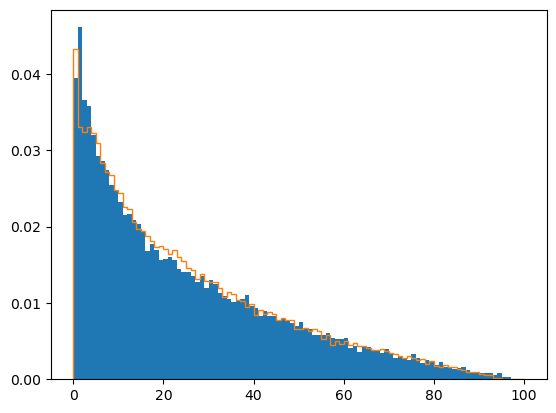

In [71]:
import torchmetrics
max_err = 0
worst_hist=None
worst_params=None
model_loaded.eval()
metrics = torchmetrics.MeanSquaredError() 
for hist, params in DataLoader(werner_dataset(wer_test), batch_size=1):
    pred = model_loaded(hist)
    err = metrics(pred, params)
    if err > max_err:
        max_err = err
        worst_hist = hist
        worst_pred = pred
        worst_params = params

alp, vis = worst_pred.detach().numpy()[0]
worst_dm = density_matrix(rho2(alp, vis))
plt.stairs(worst_hist.numpy()[0], fill=True)
plt.stairs(worst_dm.bins()['counts'])

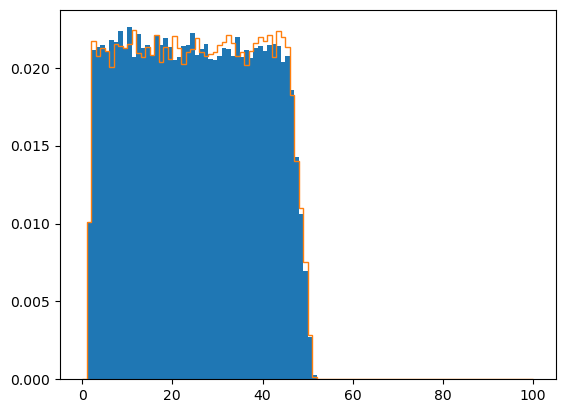

In [72]:
import torchmetrics
min_err = 80
best_hist=None
best_params=None
model_loaded.eval()
metrics = torchmetrics.MeanSquaredError() 
for hist, params in DataLoader(werner_dataset(wer_test), batch_size=1):
    pred = model_loaded(hist)
    err = metrics(pred, params)
    if err < min_err:
        min_err = err
        best_hist = hist
        best_pred = pred
        best_params = params

alp, vis = best_pred.detach().numpy()[0]
best_dm = density_matrix(rho2(alp, vis))
plt.stairs(best_hist.numpy()[0], fill=True)
plt.stairs(best_dm.bins()['counts'])